#### imprort libraries

In [1]:
import transformers 
from transformers import DistilBertModel,DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#### plot the number of labels

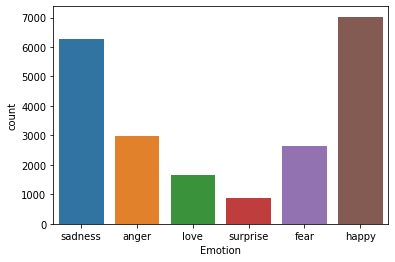

In [2]:
df = pd.read_csv("Emotion_final.csv")
sns.countplot(df.Emotion)

#### shuffle dataframe

In [3]:
for i in range(100):
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
    df = df.sample(frac = 1)
print(df)

                                                    Text  Emotion
19400  im just not mentally there but can still feel ...    happy
18246  i have panic attacks when the phone rings and ...  sadness
3981   i feel drastically inadequate for the needs i ...  sadness
13327               i feel a strange sense of foreboding     fear
17619  i almost didnt even feel convinced by the way ...    happy
...                                                  ...      ...
18555  i guess i feel kinda loyal to them since i ult...     love
10628  i focus on it when writing this i feel a bit o...    happy
9158   i know it feels like youre dying when youre wo...     love
3687   i just know i feel like i m on potentially sha...     fear
16300  i like to add things that i already completed ...    happy

[21459 rows x 2 columns]


#### change the Emotion type to integer and shuffle it

In [4]:
label_encoder = LabelEncoder()
df["Emotion"] = label_encoder.fit_transform(df["Emotion"])
print(df)

                                                    Text  Emotion
19400  im just not mentally there but can still feel ...        2
18246  i have panic attacks when the phone rings and ...        4
3981   i feel drastically inadequate for the needs i ...        4
13327               i feel a strange sense of foreboding        1
17619  i almost didnt even feel convinced by the way ...        2
...                                                  ...      ...
18555  i guess i feel kinda loyal to them since i ult...        3
10628  i focus on it when writing this i feel a bit o...        2
9158   i know it feels like youre dying when youre wo...        3
3687   i just know i feel like i m on potentially sha...        1
16300  i like to add things that i already completed ...        2

[21459 rows x 2 columns]


#### inutialization

In [5]:
print("SHAPE::",df.shape)

SHAPE:: (21459, 2)


In [6]:
class_name = ['sadness','anger','love','surprise','fear','happy']

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cpu')

#### define model

In [9]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [12]:
distilbert_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### count the lengh of tokens

100%|██████████████████████████████████████████████████████████████████████████| 21459/21459 [00:21<00:00, 1005.92it/s]


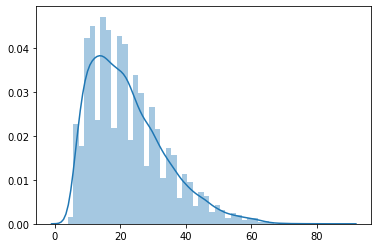

In [13]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.Text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)

#### loads data to a dictopnary

In [14]:
from torch.utils.data import Dataset, DataLoader
class TextDataset(Dataset):
    def __init__(self,texts,targets,tokenizer,max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self,item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'text_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

#### seprate train, validation and test data

In [15]:
size=len(df)
df_test = df[0:int(size/8)]
df_val = df[int(size/8):int(size/4)]
df_train = df[int(size/4):size]

In [16]:
df_train.shape, df_val.shape, df_test.shape


((16095, 2), (2682, 2), (2682, 2))

In [17]:
print(df)

                                                    Text  Emotion
19400  im just not mentally there but can still feel ...        2
18246  i have panic attacks when the phone rings and ...        4
3981   i feel drastically inadequate for the needs i ...        4
13327               i feel a strange sense of foreboding        1
17619  i almost didnt even feel convinced by the way ...        2
...                                                  ...      ...
18555  i guess i feel kinda loyal to them since i ult...        3
10628  i focus on it when writing this i feel a bit o...        2
9158   i know it feels like youre dying when youre wo...        3
3687   i just know i feel like i m on potentially sha...        1
16300  i like to add things that i already completed ...        2

[21459 rows x 2 columns]


#### calculate the weight of each class

In [18]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.Emotion.values),
                                                 df_train.Emotion.values)

In [19]:
class_weights

array([1.1980795 , 1.34125   , 0.51104972, 2.14257188, 0.57171782,
       4.04600302])

In [20]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = TextDataset(
        texts = df.Text.to_numpy(), 
        targets = df.Emotion.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

In [22]:
MAX_LEN=25
BATCH_SIZE = 5
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [36]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.drop1 = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output= pooled_output[0][:,0]
        output = self.drop(output)
        #output = self.relu(pooled_output)
        output = self.out1(output)
        output = self.relu(output)
        output = self.drop1(output)
        return self.out(output)

In [37]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

In [39]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print(data_loader)
    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [40]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
      model = model.eval()
      losses = []
      correct_predictions = 0
      with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)
          loss = loss_fn(outputs, targets)
          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())
      return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'distil_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.639450633320062 accuracy 0.8014911463187325
Val   loss 0.47188442019490767 accuracy 0.8560775540641312

Epoch 2/5
----------
Train loss 0.3696802100257091 accuracy 0.895744019881951
Val   loss 0.4915464140072762 accuracy 0.8657718120805369

Epoch 3/5
----------
Train loss 0.26688311226603517 accuracy 0.9261261261261261
Val   loss 0.6040620464495352 accuracy 0.866144668158091

Epoch 4/5
----------
Train loss 0.19870446895510535 accuracy 0.948058403230817
Val   loss 0.7190203844434863 accuracy 0.8639075316927666

Epoch 5/5
----------
Train loss 0.1425816878697702 accuracy 0.9631562597079838
Val   loss 0.7586798231535002 accuracy 0.8683818046234154



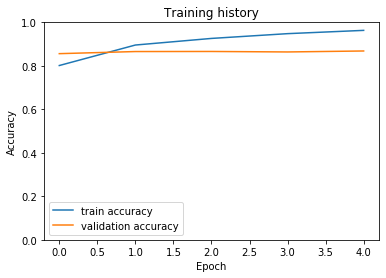

In [42]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

C:\Users\Fatemeh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.8765846383296048

In [45]:
def get_predictions(model, data_loader):
    model = model.eval()
    text_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["text_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            text_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return text_texts, predictions, prediction_probs, real_values

In [46]:
y_text_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [47]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

     sadness       0.89      0.89      0.89       372
       anger       0.83      0.82      0.82       316
        love       0.91      0.89      0.90       920
    surprise       0.72      0.76      0.74       187
        fear       0.91      0.93      0.92       773
       happy       0.75      0.73      0.74       114

    accuracy                           0.88      2682
   macro avg       0.83      0.84      0.83      2682
weighted avg       0.88      0.88      0.88      2682



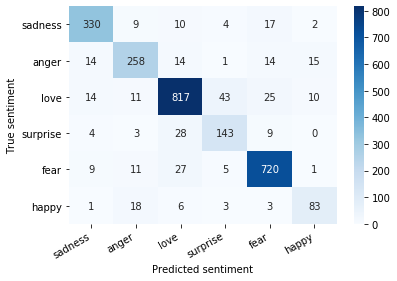

In [48]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)